<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Treinamento_de_redes_neurais_com_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps
Uma amostra do dataset CelebA foi utilizada para treinar a rede ResNet50, usando transfer learning.

* 1. _data selection_: o arquivo com os atributos das imagens previamente selecionadas foi carregado. Em seguida o dataset de atributos, usado como referência, foi 'misturado' (efeito shuffle). Os conjuntos de treino, teste e validação também foram criados, na proporção 0,7:0,15:0,15.
[Feature Engineering Celeb A](https://github.com/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Feature_Engineering_Celeb_A.ipynb)

* 2. _data preparation_: a partir do dataset referência, as imagens do diretório foram carregadas e devidamente tratadas, sendo reunidas em datasets de imagens do tensorflow.

* 3. _transfer learning_: a rede ResNet50 foi importada com seus pesos oriundos do treinamento com a base `imagenet`, suas camadas foram congeladas, exceto a última, a qual foi adaptada para a saída de classificação deste problema multilabel. Depois, o modelo foi ajustado, processo conhecido como fine tunning que consiste em descongelar algumas camadas da rede.

* 4. _evaluation_: os modelos foram brevemente avaliados em função das métricas AUC, Precision e Recall. A função de perda utilizada foi BinaryCrossentropy.

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-multilearn
!pip install mtcnn
!pip install lz4
from IPython.display import clear_output
import tensorflow as tf
import cv2
from mtcnn import MTCNN
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, random_rotation
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.regularizers import l2
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils import shuffle
from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
clear_output()

## helpers
- Funções usadas para preparar os dados e treinar a rede.

__Dataset Manager__
- Essa classe é responsável por ler o dataset CelebA e fazer o processamento das faces, recortando e alinhando. Isso é possível porque o dataset possui um arquivo de bounding box e um de landmarks.
- Essas imagens depois de processadas são entregues à rede para treino

In [14]:
class DatasetManager:
    def __init__(self, img_dir, attr_csv_path, landmarks_csv_path, img_size=(224, 224), seed=42):
        """
        Gerencia o carregamento e processamento do dataset para o modelo.

        :param img_dir: Diretório das imagens.
        :param attr_csv_path: Caminho para o arquivo CSV com atributos.
        :param bbox_csv_path: Caminho para o arquivo CSV com bounding boxes.
        :param landmarks_csv_path: Caminho para o arquivo CSV com landmarks.
        :param img_size: Dimensão de entrada das imagens (largura, altura).
        :param seed: Semente para reprodutibilidade.
        """
        self.img_dir = Path(img_dir)
        self.attr_csv_path = Path(attr_csv_path)
        self.landmarks_csv_path = Path(landmarks_csv_path)
        self.img_size = img_size
        self.seed = seed
        self.dataframe = None
        self.bbox_df = None
        self.landmarks_df = None
        self.datasets = {}
        self.detector = MTCNN()

    def load(self):
        """
        Carrega os CSVs de atributos, bounding boxes e landmarks.
        """
        # Verifica se os arquivos existem
        for path in [self.attr_csv_path, self.landmarks_csv_path]:
            if not path.is_file():
                raise FileNotFoundError(f"Arquivo não encontrado: {path}")
        if not self.img_dir.is_dir():
            raise FileNotFoundError(f"Diretório de imagens não encontrado: {self.img_dir}")

        # Carrega os DataFrames
        self.dataframe = pd.read_csv(self.attr_csv_path).replace(-1, 0)
        self.landmarks_df = pd.read_csv(self.landmarks_csv_path)

        # Filtra imagens disponíveis
        available_images = set(os.listdir(self.img_dir))
        self.dataframe = self.dataframe[self.dataframe['image_id'].isin(available_images)]
        available_images = set(self.dataframe['image_id'])
        self.landmarks_df = self.landmarks_df[self.landmarks_df['image_id'].isin(available_images)]

    def multilabel_stratified_split(self, test_size=0.3):
        """
        """
        if self.dataframe is None:
            raise ValueError("DataFrame não carregado. Chame o método 'load' antes.")

        X = self.dataframe.loc[:, 'image_id'].values.reshape(-1, 1)
        y = self.dataframe.iloc[:, 1:].values
        X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.3)
        X_test, y_test, X_val, y_val = iterative_train_test_split(X_test, y_test, test_size=0.5)

        train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
        train.columns = self.dataframe.columns
        test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)
        test.columns = self.dataframe.columns
        val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(y_val)], axis=1)
        val.columns = self.dataframe.columns

        self.datasets = {
            'train': train,
            'val': val,
            'test': test
        }

    def extract_landmarks_mtcnn(self, img):
        """
        Extrai bounding boxes e landmarks de uma imagem usando MTCNN.
        :param img: Imagem como array NumPy.
        :return: Dicionário com bounding box e landmarks.
        """
        detections = self.detector.detect_faces(img)
        if len(detections) == 0:
            raise ValueError("Nenhuma face detectada.")

        face = detections[0]
        bounding_box = face['box']  # [x, y, width, height]
        landmarks = face['keypoints']  # {'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'}
        return bounding_box, landmarks

    def align_face(self, img, left_eye, right_eye, nose):
        """
        Alinha a face para que os olhos fiquem horizontais e o rosto fique centralizado.
        :param img: Imagem original.
        :param left_eye: Coordenadas do olho esquerdo (x, y).
        :param right_eye: Coordenadas do olho direito (x, y).
        :param nose: Coordenadas do nariz (x, y).
        :return: Imagem alinhada.
        """
        # Calcula o ângulo entre os olhos
        dx = right_eye[0] - left_eye[0]
        dy = right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(dy, dx))

        # Centro do rosto (entre os olhos e o nariz)
        center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

        # Matriz de rotação
        M = cv2.getRotationMatrix2D(center, angle, scale=1)

        # Alinha a imagem
        aligned_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        return aligned_img

    def normalize_contrast(seld, img):
        """
        Normaliza o contraste da imagem usando CLAHE.
        :param img: Imagem original.
        :return: Imagem com contraste normalizado.
        """
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        normalized_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return normalized_img

    def crop_expanded_bbox(self, img, landmarks=None, bbox=None):
        """
        Recorta a imagem com base em um bounding box fornecido ou recalcula-o a partir dos landmarks.
        O recorte mantém o centro do bounding box como ponto de referência e redimensiona para o tamanho padrão.

        :param img: Imagem original como array NumPy.
        :param landmarks: Coordenadas dos landmarks faciais.
        :param bbox: Bounding box fornecido como (x1, y1, width, height). Opcional.
        :return: Imagem processada (recortada, alinhada e redimensionada).
        """
        assert (landmarks is not None) or (bbox is not None), "Either landmarks or bbox must be provided."
        if bbox is not None:
            x1, y1, width, height = bbox
            x2, y2 = x1 + width, y1 + height
        else:
            landmark_points = list(landmarks.values())

            x1 = min([it[0] for it in landmark_points])
            y1 = min([it[1] for it in landmark_points])
            x2 = max([it[0] for it in landmark_points])
            y2 = max([it[1] for it in landmark_points])

        # Calcula largura, altura e centro do bounding box
        width = x2 - x1
        height = y2 - y1
        center = (y1 + height // 2, x1 + width // 2)

        new_y1 = center[0] - min(center[0], img.shape[0] - center[0])
        new_x1 = center[1] - min(center[1], img.shape[1] - center[1])
        new_height = 2 * min(center[0], img.shape[0] - center[0])
        new_width = 2 * min(center[1], img.shape[1] - center[1])

        cropped_img = img[new_y1:new_y1 + new_height, new_x1:new_x1 + new_width]

        target_height, target_width = self.img_size
        cropped_img = tf.image.resize_with_pad(
            cropped_img, target_height=target_height, target_width=target_width
        )
        cropped_img = cropped_img.numpy().astype('uint8')
        return cropped_img / 255.0

    def create_tf_dataset(self, split='train', augment=False):
        """
        Cria um dataset do TensorFlow para um split específico.

        :param split: Qual split usar (train, val, test).
        :param augment: Se True, aplica augmentação.
        :return: Um objeto tf.data.Dataset.
        """
        if split not in self.datasets:
            raise ValueError(f"Split '{split}' não encontrado. Disponíveis: {list(self.datasets.keys())}")

        def load_image_and_labels(record):
            """
            Carrega uma imagem e seus rótulos correspondentes, aplicando bounding box e alinhamento.
            """
            img_path = os.path.join(self.img_dir, record['image_id'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            l = self.landmarks_df[self.landmarks_df['image_id'] == record['image_id']].iloc[0, 1:].to_dict()
            landmarks = {
                'nose': (l['nose_x'], l['nose_y']),
                'mouth_right': (l['rightmouth_x'], l['rightmouth_y']),
                'mouth_left': (l['leftmouth_x'], l['leftmouth_y']),
                'right_eye': (l['righteye_x'], l['righteye_y']),
                'left_eye': (l['lefteye_x'], l['lefteye_y']),
            }

            processed_img = self.align_face(img, landmarks['left_eye'], landmarks['right_eye'], landmarks['nose'])
            processed_img = self.normalize_contrast(processed_img)
            processed_img = self.crop_expanded_bbox(processed_img, landmarks)

            labels = tf.convert_to_tensor(list(record.values())[1:], dtype=tf.float32)
            return processed_img, labels

        data = self.datasets[split].to_dict(orient='records')
        dataset = tf.data.Dataset.from_generator(
            lambda: (load_image_and_labels(record) for record in data),
            output_signature=(
                tf.TensorSpec(shape=(*self.img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(len(data[0]) - 1,), dtype=tf.float32)
            )
        )

        if augment:
            def augment_image(image, label):
                image = data_augmentation(image, training=True)
                image = tf.clip_by_value(image, 0.0, 1.0)
                return image, label

            data_augmentation = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1, 0.1),
                tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                tf.keras.layers.RandomBrightness(factor=0.1, value_range=[0.0, 1.0]),
                tf.keras.layers.GaussianNoise(stddev=0.02)
            ])

            dataset = dataset.map(
                lambda image, label: augment_image(image, label),
                num_parallel_calls=tf.data.AUTOTUNE
            )
        return dataset

    def preprocess_image(self, image_path):
        """
        Pipeline completo para pré-processar uma imagem para o modelo.
        :param image_path: Caminho para a imagem.
        :return: Imagem pré-processada.
        """
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bbox, landmarks = self.extract_landmarks_mtcnn(img)

        aligned_img = self.align_face(img, landmarks['left_eye'], landmarks['right_eye'], landmarks['nose'])
        contrast_img = self.normalize_contrast(aligned_img)
        processed_img = self.crop_expanded_bbox(contrast_img, landmarks=landmarks, bbox=None)
        return processed_img

@register_keras_serializable()
class MultilabelResNet50(Model):
    def __init__(self, num_classes=40, base_trainable=False, **kwargs):
        """
        Modelo para classificação multilabel baseado em ResNet50.

        :param num_classes: Número de classes para classificação.
        :param base_trainable: Se True, a base ResNet50 será treinável (TODO: não suportado ainda.).
        """
        super(MultilabelResNet50, self).__init__(**kwargs)
        self.base_model = ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3)
        )
        self.base_model.trainable = base_trainable
        self.global_pooling = GlobalAveragePooling2D()
        self.batch_norm = BatchNormalization()
        self.dropout = Dropout(0.5)
        self.classifier = Dense(num_classes, activation="sigmoid", kernel_regularizer=l2(0.01), name="classifier")

    def call(self, inputs, training=False):
        """
        Forward pass do modelo.

        :param inputs: Entradas do modelo.
        :param training: Indica se o modelo está em treinamento.
        :return: Predições multilabel.
        """
        x = self.base_model(inputs, training=training)
        x = self.global_pooling(x)
        x = self.batch_norm(x, training=training)
        x = self.dropout(x, training=training)
        outputs = self.classifier(x)
        return outputs

    def get_config(self):
        """
        Retorna a configuração do modelo como um dicionário.
        """
        config = super(MultilabelResNet50, self).get_config()
        config.update({
            "num_classes": self.classifier.units,
            "base_trainable": self.base_model.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):  # Add from_config method
        """
        Cria uma instância do modelo a partir de sua configuração.
        """
        return cls(**config)  # Instantiate the class with the loaded configuration

    def compile_model(self, learning_rate=0.001):
        """
        Compila o modelo com configuração padrão.

        :param learning_rate: Taxa de aprendizado do otimizador.
        """
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.AUC(name="auc", multi_label=True),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall")
            ]
        )

    def fit_model(self, train_dataset, val_dataset, steps_per_epoch, validation_steps, epochs=10, batch_size=32, callbacks=None):
        """
        Treina o modelo com os datasets fornecidos.

        :param train_dataset: Dataset de treinamento.
        :param val_dataset: Dataset de validação.
        :param epochs: Número de épocas.
        :param callbacks: Lista de callbacks do Keras.
        :return: Histórico do treinamento.
        """
        if callbacks is None:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor="auc", patience=3, mode="max", restore_best_weights=True
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    filepath="best_model.keras", monitor="auc", save_best_only=True
                ),
                tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
            ]

        history = self.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history

    def fine_tune(self, train_dataset, val_dataset, steps_per_epoch, validation_steps, epochs, initial_epochs, batch_size, learning_rate, layers_to_unfreeze=10):
        """
        Realiza fine-tuning no modelo descongelando as camadas superiores da base.

        :param train_dataset: Dataset de treinamento.
        :param val_dataset: Dataset de validação.
        :param initial_epochs: Número de épocas para treinamento inicial com a base congelada.
        :param fine_tune_epochs: Número total de épocas após descongelar as camadas superiores.
        :param learning_rate: Taxa de aprendizado reduzida para fine-tuning.
        :param layers_to_unfreeze: Número de camadas superiores a serem descongeladas.
        :return: Histórico do treinamento com fine-tuning.
        """
        self.base_model.trainable = True
        for layer in self.base_model.layers[:-layers_to_unfreeze]:
            layer.trainable = False

        self.compile_model(learning_rate=learning_rate)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="auc", patience=3, mode="max", restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="best_model.keras", monitor="auc", save_best_only=True
            ),
            tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
        ]

        history_fine_tune = self.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            initial_epoch=initial_epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history_fine_tune

    def evaluate_model(self, test_dataset, steps):
        """
        Avalia o modelo com o conjunto de teste e salva os resultados.

        :param test_dataset: Dataset de teste.
        :param steps: Número de passos para a avaliação.
        :return: Resultados da avaliação e predições.
        """
        evaluation_per_epoch = self.evaluate(test_dataset, steps=steps, return_dict=True)

        y_true = []
        y_pred = []
        for x, y in test_dataset:
            preds = self.predict(x)
            binarized_preds = (preds > 0.5).astype(int)
            y_true.extend(y.numpy())
            y_pred.extend(binarized_preds)

        import pandas as pd
        predictions = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})

        return evaluation_per_epoch, predictions

    def predict_image(self, image_path=None, image=None):
        """
        Realiza a predição para uma única imagem.

        :param image_path: Caminho para a imagem a ser classificada.
        :param image: imagem a ser classificada.
        :return: Classificações da imagem.
        """
        assert (image_path is not None) or (image is not None), "Either image_path or image must be provided."

        if image_path is not None:
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (224, 224)) / 255.0
        elif image is not None:
            img = image
            img = img * 255

        img = preprocess_input(img)
        img = tf.expand_dims(img, axis=0)
        predictions = self.predict(img)
        binarized_predictions = (predictions > 0.5).astype(int)
        return binarized_predictions

def plot_training_finetune_history_grid(history:dict, fine_tune_point, save_as=''):
    """
    Plota as métricas de treinamento e validação ao longo das épocas em uma grade 2x2.

    :param history: Objeto retornado por model.fit() contendo histórico do treinamento.
    """
    metrics = [m for m in history.keys() if not m.startswith('val_')]
    val_metrics = [f"val_{m}" for m in metrics]

    num_metrics = len(metrics)
    rows, cols = 2, 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.set_title(f'{metric.capitalize()} por Época')
        ax.set_xlabel('Épocas')
        ax.set_xticks(range(0, len(history[metric]), 5))
        ax.set_ylabel(metric.capitalize())
        ax.plot(history[metric], label=f'Treinamento - {metric}')
        ax.plot(history[val_metric], label=f'Validação - {val_metric}')
        ax.legend()
        ax.grid(True)

        ax.axvline(fine_tune_point - 1, color='gray', linestyle='--', label='Fine-tuning start')

    # Remove eixos vazios se houver menos de 4 métricas
    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

## Settings

In [4]:
base_dir = "base_dir"
csv_attributes_path = os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv')
bounding_box_path = os.path.join(base_dir, 'datasets/celeb_a/list_bbox_celeba.csv')
landmarks_path = os.path.join(base_dir, 'datasets/celeb_a/list_landmarks_align_celeba.csv')

img_dir = os.path.join(base_dir, 'datasets/celeb_a/celeb_a_images')

VAR = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 64,
    'EPOCHS': 20,
    'FINE_TUNE_EPOCHS': 30,
    'SEED': 42,
    'LEARNING_RATE': 0.001,
    'LEARNING_RATE_FINE_TUNE': 1e-5,
    'NUM_CLASSES': 39
}

## Data preparation
A classe DatasetManager é responsável por todo o pipeline de dados.

`.load()` lê o arquivo de atributos das imagens; `.multilabel_stratified_split()` utiliza skmultilearn para divisão multilabel estratificada; `.create_tf_dataset()` carrega e prepara os conjuntos de imagens.

In [5]:
dataset_manager = DatasetManager(
    img_dir=img_dir,
    attr_csv_path=csv_attributes_path,
    landmarks_csv_path=landmarks_path,
    img_size=VAR['IMG_SIZE'],
    seed=VAR['SEED']
)
dataset_manager.load()
dataset_manager.dataframe.shape

(3899, 40)

Classe menos representada: Blurry = 221
Classe mais representada: No_Beard = 2919


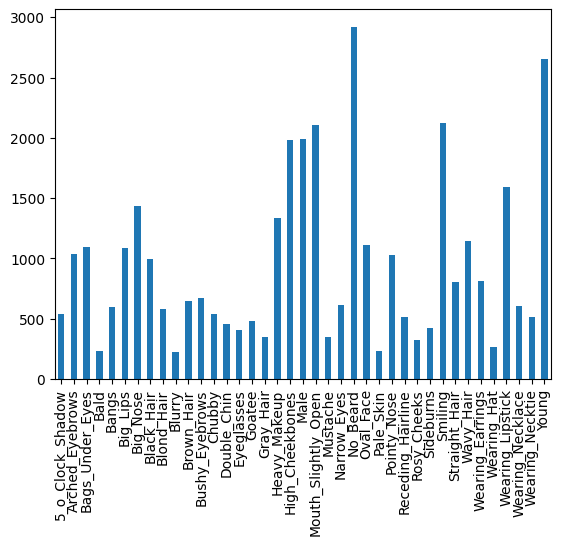

In [6]:
print(f'Classe menos representada: {dataset_manager.dataframe.columns[1:][dataset_manager.dataframe.iloc[:, 1:].sum().argmin()]} = {dataset_manager.dataframe.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {dataset_manager.dataframe.columns[1:][dataset_manager.dataframe.iloc[:, 1:].sum().argmax()]} = {dataset_manager.dataframe.iloc[:, 1:].sum().max()}')
dataset_manager.dataframe.iloc[:, 1:].sum().plot(kind='bar');

In [7]:
%%time
dataset_manager.multilabel_stratified_split()
train_dataset = dataset_manager.create_tf_dataset(split='train', augment=True).cache()
val_dataset = dataset_manager.create_tf_dataset(split='val', augment=False).cache()
test_dataset = dataset_manager.create_tf_dataset(split='test', augment=False).cache()

CPU times: user 4.22 s, sys: 103 ms, total: 4.32 s
Wall time: 4.87 s


In [8]:
[f"{k}: {v.shape}" for k, v in dataset_manager.datasets.items()]

['train: (2719, 40)', 'val: (590, 40)', 'test: (590, 40)']

In [9]:
# Desvio relativo à média: treino, validação e teste possuem a mesma distribuição de classes.
[f"{k}: {np.std(np.sum(v.iloc[:, 1:].values, axis=0)) / np.mean(np.sum(v.iloc[:, 1:].values, axis=0))}" for k, v in dataset_manager.datasets.items()]

['train: 0.7260825808966921',
 'val: 0.7175474273418266',
 'test: 0.7135922564243337']

__Como as imagens do treino com data augmentation ficaram__

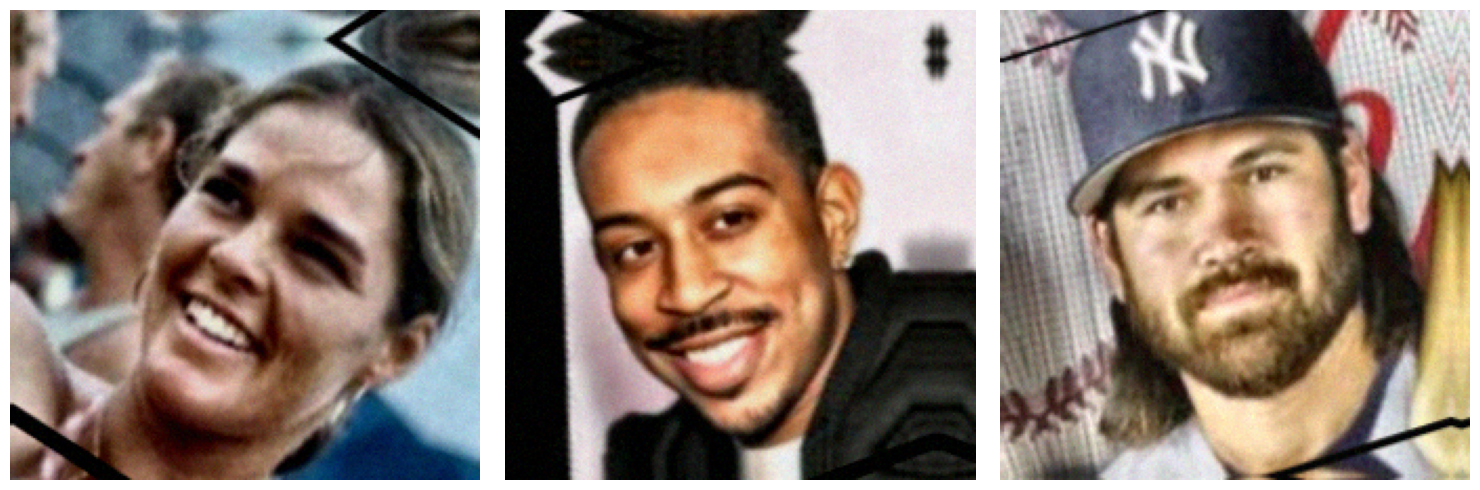

In [10]:
train_iter = iter(train_dataset)
images, labels = [], []
for _ in range(3):
    img, lbl = next(train_iter)
    images.append(img.numpy())
    labels.append(lbl.numpy())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

__Como as imagens sem data augmentation estão__

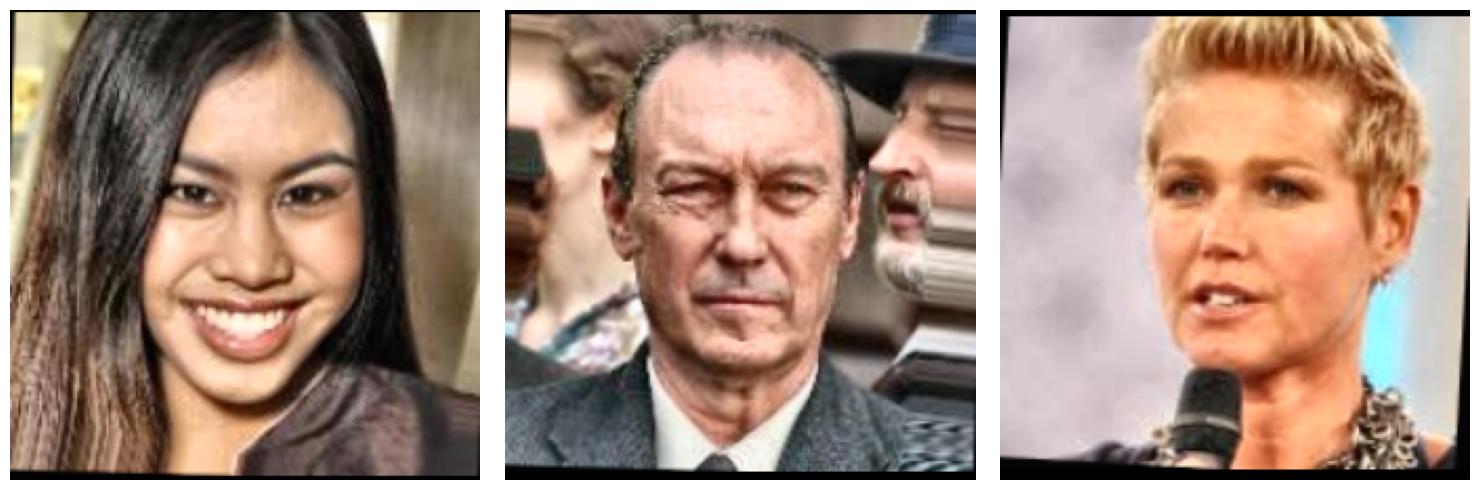

In [15]:
train_iter = iter(test_dataset)
images, labels = [], []
for _ in range(3):
    img, lbl = next(train_iter)
    images.append(img.numpy())
    labels.append(lbl.numpy())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Modelling

A classe MultilabelResNet50 é responsável por todo o pipeline de treino da rede. Nesse problema a rede será treinada por 10 épocas e depois suas últimas camadas serão descongeladas para ajuste, e o treino continuará por mais 20 épocas a uma taxa de aprendizado um pouco menor com decaimento.

In [11]:
%%time
model = MultilabelResNet50(num_classes=VAR['NUM_CLASSES'], base_trainable=False)

steps_per_epoch = int(np.ceil(dataset_manager.datasets['train'].shape[0] / VAR['BATCH_SIZE']))
validation_steps = int(np.ceil(dataset_manager.datasets['val'].shape[0] / VAR['BATCH_SIZE']))

model.compile_model(learning_rate=VAR['LEARNING_RATE'])
history = model.fit_model(
    train_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    val_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps_per_epoch,
    validation_steps,
    epochs=VAR['EPOCHS'],
    batch_size=VAR['BATCH_SIZE'],
)
epochs_executed = len(history.history['auc'])
history_fine_tune = model.fine_tune(
    train_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    val_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps_per_epoch,
    validation_steps,
    epochs=epochs_executed + VAR['FINE_TUNE_EPOCHS'],
    initial_epochs=epochs_executed,
    batch_size=VAR['BATCH_SIZE'],
    learning_rate=VAR['LEARNING_RATE_FINE_TUNE'],
    layers_to_unfreeze=10
)

model.save(os.path.join(base_dir, 'projeto_1/output/models/ResNet50_CelebA.keras'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3139s 72s/step - auc: 0.5206 - loss: 1.1928 - precision: 0.2694 - recall: 0.4879 - val_auc: 0.6060 - val_loss: 0.7185 - val_precision: 0.3772 - val_recall: 0.5453
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 594s 14s/step - auc: 0.5894 - loss: 0.6171 - precision: 0.5803 - recall: 0.3503 - val_auc: 0.6467 - val_loss: 0.5610 - val_precision: 0.5378 - val_recall: 0.3957
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 596s 14s/step - auc: 0.6337 - loss: 0.5257 - precision: 0.6429 - recall: 0.3265 - val_auc: 0.6618 - val_loss: 0.5238 - val_precision: 0.6241 - val_recall: 0.3170
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 597s 14s/step - auc: 0.6414 - loss: 0.5052 - precision: 0.6573 - recall: 0.3192 - val_auc: 0.6700 - val_loss: 0.5115 - val_precision: 0.6389 - val_recall: 0.3174
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 604s 14s/step - auc: 0.6527 - loss: 0.4958 - precision: 0.6640 - recall: 0.3231 - val_auc: 0.6749 - val_loss: 

In [12]:
plot = dict()
for k in history.history.keys():
    plot[k] = history.history[k] + history_fine_tune.history[k]
pd.DataFrame(plot).to_csv(os.path.join(base_dir, 'projeto_1/output/ResNet50_CelebA_training_finetune_history.csv'), index=False)

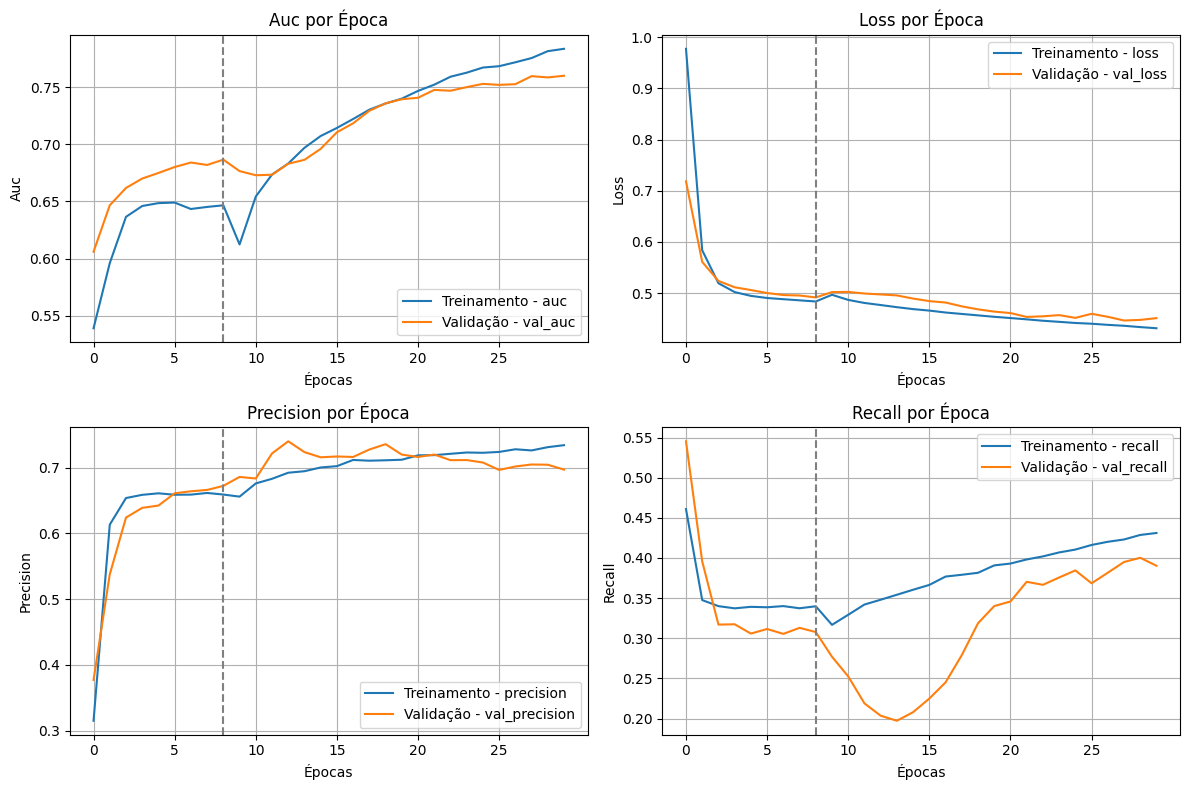

In [16]:
plot_training_finetune_history_grid(
    history=plot,
    fine_tune_point=len(history.history['auc']),
    save_as=os.path.join(base_dir, 'projeto_1/output/images/ResNet50_CelebA_training_finetune_history.png')
)

## Evaluation

In [17]:
steps = int(np.ceil(dataset_manager.datasets['test'].shape[0] / VAR['BATCH_SIZE']))
evaluation_per_epoch, predictions = model.evaluate_model(
    test_dataset.batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps=steps
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 574s 56s/step - auc: 0.7383 - loss: 0.4636 - precision: 0.6960 - recall: 0.3915
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [18]:
print(evaluation_per_epoch)
display(predictions.head())

{'auc': 0.7445191740989685, 'loss': 0.4563401937484741, 'precision': 0.6994639039039612, 'recall': 0.3994956910610199}


y_true  \
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
4  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   

                                              y_pred  
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [19]:
predictions.to_csv(os.path.join(base_dir, 'assets/ResNet50_CelebA_predictions.csv'), index=False)

## Predicting a random image

In [20]:
df = pd.read_csv(os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv')).replace(-1, 0)
df = df[df['image_id'].isin(set(os.listdir(img_dir)))].reset_index(drop=True)

In [21]:
model = tf.keras.models.load_model(
    os.path.join(base_dir, 'projeto_1/output/models/ResNet50_CelebA.keras'),
    custom_objects={'MultilabelResNet50': MultilabelResNet50}
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 433 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
dm = DatasetManager(
    img_dir=img_dir,
    attr_csv_path=csv_attributes_path,
    landmarks_csv_path=landmarks_path,
    img_size=VAR['IMG_SIZE'],
    seed=VAR['SEED']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Error: Could not load image at /content/drive/MyDrive/DIO Baires Dev/assets/images/.ipynb_checkpoints


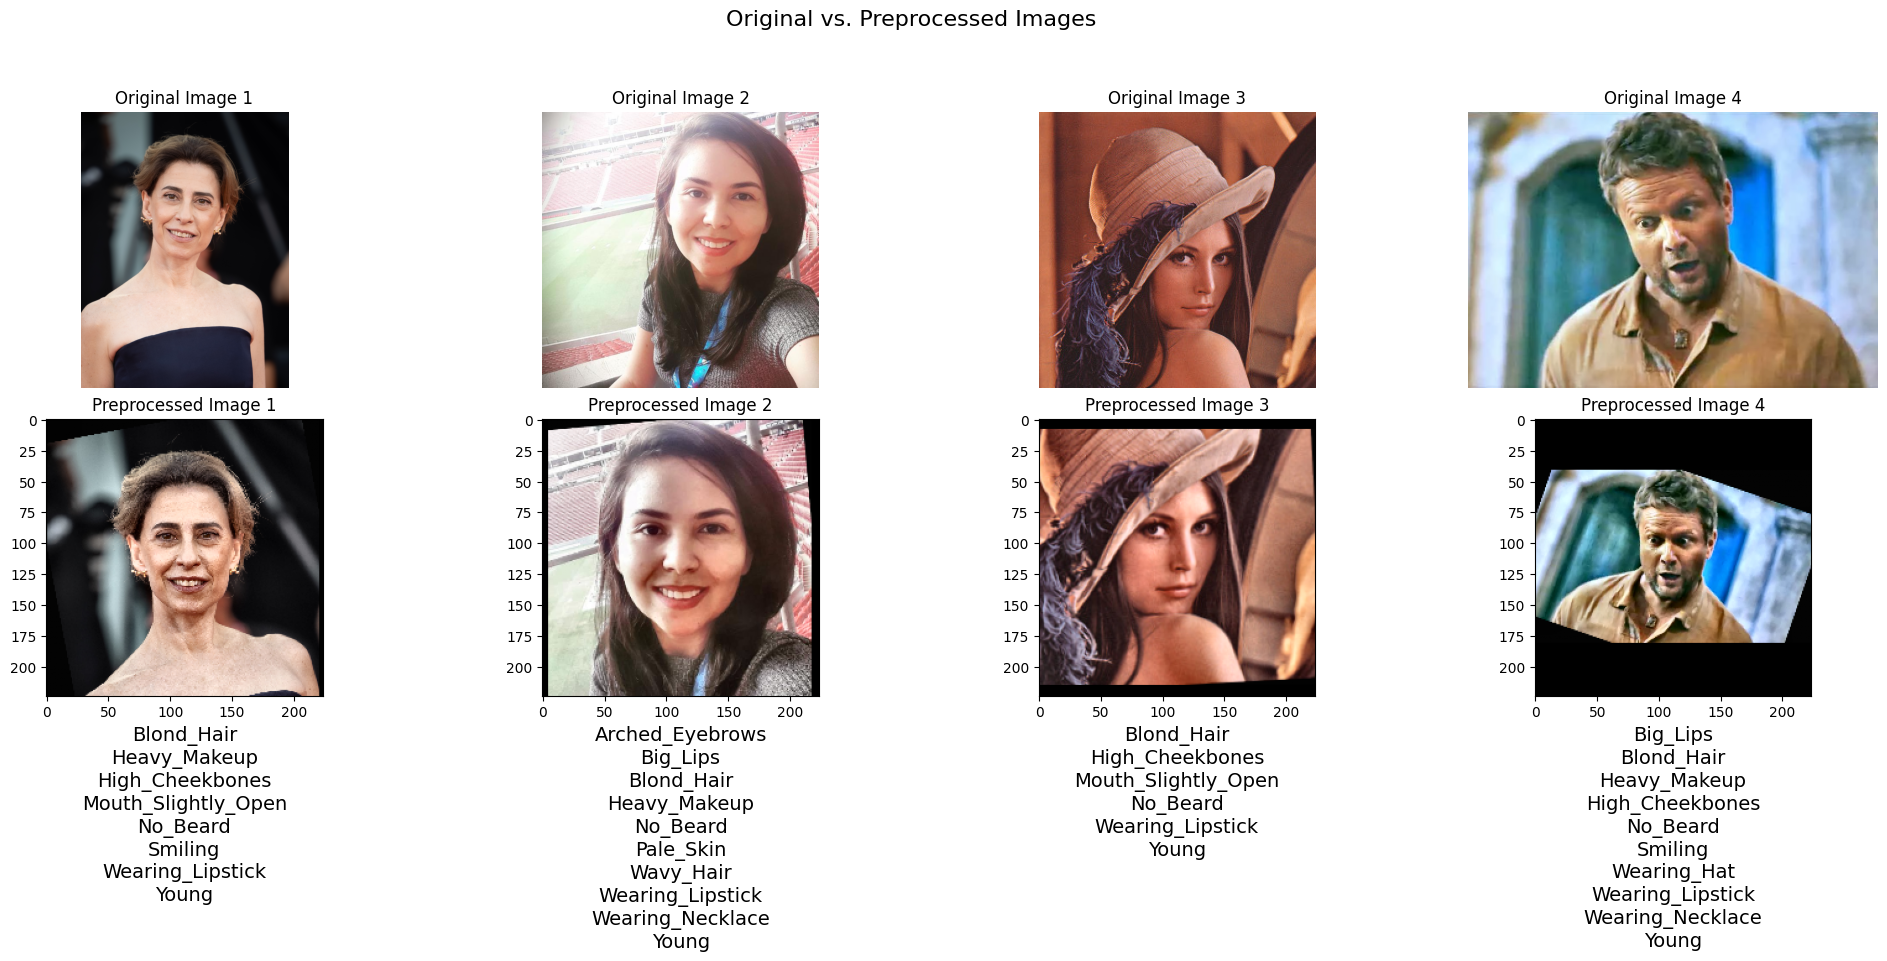

In [49]:
def preprocess_and_plot_predicted_images(image_paths, save_as=''):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Original vs. Preprocessed Images', fontsize=16)

    for i, image_path in enumerate(image_paths):
      row = 0
      col = i % 4

      img = cv2.imread(image_path)
      if img is None:
          print(f"Error: Could not load image at {image_path}")
          continue
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[row, col].imshow(img)
      axes[row, col].set_title(f"Original Image {i+1}")
      axes[row, col].axis('off')

      preprocessed_image = dm.preprocess_image(image_path)
      axes[row + 1, col].imshow(preprocessed_image)
      axes[row + 1, col].set_title(f"Preprocessed Image {i+1}")

      x = model.predict_image(image=preprocessed_image)
      x = pd.Series(x[0], index=df.columns[1:], name='Prediction')
      axes[row + 1, col].set_xlabel('\n'.join(x.index[x == 1].values), fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_as:
        plt.savefig(save_as)
    plt.show()

image_files = [os.path.join(base_dir, 'assets/images', it) for it in os.listdir(os.path.join(base_dir, 'assets/images'))]
preprocess_and_plot_predicted_images(image_files, save_as=os.path.join(base_dir, 'projeto_1/output/images/images_grid_with_predictions.png'))